<a href="https://colab.research.google.com/github/MRdvan/Pytorch-Training/blob/master/Weather_Classification_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3107, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3107 (delta 14), reused 33 (delta 11), pack-reused 3067
Receiving objects: 100% (3107/3107), 640.08 MiB | 44.36 MiB/s, done.
Resolving deltas: 100% (1766/1766), done.
Checking out files: 100% (218/218), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [4]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/MyDrive")
image_path = data_path / "weatherdataset_splited"

# Setup Dirs
train_dir = image_path / "train"
val_dir = image_path / "val"

In [5]:
#pip install split-folders
#import splitfolders
#splitfolders.ratio('/content/drive/MyDrive/WeatherDataset/Multi-class Weather Dataset', output="/content/drive/MyDrive/weatherdataset_splited", seed=42, ratio=(.8, .2)) 

In [6]:
os.listdir("/content/drive/MyDrive/weatherdataset_splited/")

['train', 'val']

### Prepare data

                transforms.ToPILImage(),
                transforms.CenterCrop((100, 100)),
                transforms.RandomCrop((80, 80)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=(-90, 90)),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.Resize((156, 156)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

In [78]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [79]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=val_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f11fa693c50>,
 ['Cloudy', 'Rain', 'Shine', 'Sunrise'])

#Build CNN model

In [80]:
class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture."""

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, 
                  out_channels=hidden_units*2,
                  kernel_size=3, 
                  stride=1, 
                  padding=0),  
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*2, 
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
      )
        self.conv_block_3 = nn.Sequential(
          nn.Conv2d(hidden_units*2, hidden_units*4, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units*4, hidden_units*4, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=23040,
                    out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x

In [81]:
model_vgg = TinyVGG(3,10,4).to(device)

In [88]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg.parameters(), lr=0.001,weight_decay = 0.000005)

In [89]:
# Training 
num_epochs = 20
torch.manual_seed(42)
model_vgg.load_state_dict(torch.load("/content/drive/MyDrive/weatherdataset_splited/saved_models/vgg_regularization_93%.pth"))
engine.train(model_vgg,train_dataloader,test_dataloader,optimizer,loss_fn,num_epochs,device)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1747 | train_acc: 0.9278 | test_loss: 0.8279 | test_acc: 0.8320
Epoch: 2 | train_loss: 0.0904 | train_acc: 0.9644 | test_loss: 1.0586 | test_acc: 0.8359
Epoch: 3 | train_loss: 0.1235 | train_acc: 0.9634 | test_loss: 0.8053 | test_acc: 0.8320
Epoch: 4 | train_loss: 0.0939 | train_acc: 0.9644 | test_loss: 0.9646 | test_acc: 0.8438
Epoch: 5 | train_loss: 0.1079 | train_acc: 0.9644 | test_loss: 0.6276 | test_acc: 0.8125
Epoch: 6 | train_loss: 0.0989 | train_acc: 0.9612 | test_loss: 1.1137 | test_acc: 0.7891
Epoch: 7 | train_loss: 0.1300 | train_acc: 0.9720 | test_loss: 0.9167 | test_acc: 0.8086
Epoch: 8 | train_loss: 0.1763 | train_acc: 0.9666 | test_loss: 0.7443 | test_acc: 0.8359
Epoch: 9 | train_loss: 0.0673 | train_acc: 0.9752 | test_loss: 1.2448 | test_acc: 0.8125
Epoch: 10 | train_loss: 0.0639 | train_acc: 0.9763 | test_loss: 0.8692 | test_acc: 0.8359
Epoch: 11 | train_loss: 0.0521 | train_acc: 0.9817 | test_loss: 0.9706 | test_acc: 0.8359
Epoch: 12 | train_l

{'train_loss': [0.1747146771000377,
  0.09037673840267134,
  0.12354877302101974,
  0.09394813364307428,
  0.10793016982618077,
  0.09894536010086022,
  0.1299898925614704,
  0.17631750791494188,
  0.06725526048705496,
  0.06386475042231253,
  0.052053167452586105,
  0.026567032376047354,
  0.04795428881409642,
  0.02987713140339173,
  0.03623931949701289,
  0.05134367442224175,
  0.039525781870530595,
  0.038967961399286086,
  0.07844196247129605,
  0.09645643794973349],
 'train_acc': [0.927801724137931,
  0.9644396551724138,
  0.9633620689655172,
  0.9644396551724138,
  0.9644396551724138,
  0.9612068965517241,
  0.9719827586206896,
  0.9665948275862069,
  0.9752155172413793,
  0.9762931034482759,
  0.9816810344827587,
  0.9924568965517241,
  0.9870689655172413,
  0.990301724137931,
  0.9881465517241379,
  0.9827586206896551,
  0.9859913793103449,
  0.9870689655172413,
  0.9719827586206896,
  0.9665948275862069],
 'test_loss': [0.8278612752910703,
  1.0585758304223418,
  0.8052869029

In [90]:
from going_modular.going_modular import utils
utils.save_model(model_vgg,"/content/drive/MyDrive/weatherdataset_splited/saved_models","vgg_regularization_96%.pth")

[INFO] Saving model to: /content/drive/MyDrive/weatherdataset_splited/saved_models/vgg_regularization_96%.pth


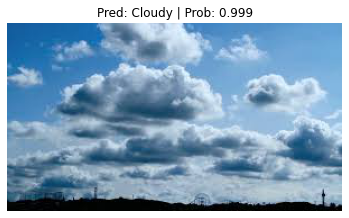

In [91]:
predictions.pred_and_plot_image(model_vgg,class_names,'/content/drive/MyDrive/weatherdataset_splited/val/Cloudy/cloudy92.jpg',(224,224),transform=simple_transform,device=device)

### Get and prepare a pretrained model

In [9]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [13]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9968 | train_acc: 0.6724 | test_loss: 0.6295 | test_acc: 0.8789
Epoch: 2 | train_loss: 0.5650 | train_acc: 0.8545 | test_loss: 0.4629 | test_acc: 0.8984
Epoch: 3 | train_loss: 0.4081 | train_acc: 0.9159 | test_loss: 0.3692 | test_acc: 0.9023
Epoch: 4 | train_loss: 0.3429 | train_acc: 0.9195 | test_loss: 0.3132 | test_acc: 0.9023
Epoch: 5 | train_loss: 0.2962 | train_acc: 0.9188 | test_loss: 0.2810 | test_acc: 0.9180
Epoch: 6 | train_loss: 0.2556 | train_acc: 0.9343 | test_loss: 0.2872 | test_acc: 0.9336
Epoch: 7 | train_loss: 0.2206 | train_acc: 0.9591 | test_loss: 0.2419 | test_acc: 0.9219
Epoch: 8 | train_loss: 0.2166 | train_acc: 0.9368 | test_loss: 0.2393 | test_acc: 0.9336
Epoch: 9 | train_loss: 0.1908 | train_acc: 0.9461 | test_loss: 0.2653 | test_acc: 0.9219
Epoch: 10 | train_loss: 0.1961 | train_acc: 0.9504 | test_loss: 0.2392 | test_acc: 0.9141
[INFO] Total training time: 201.494 seconds


### Make predictions on the entire test dataset with the model

In [14]:
# TODO
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
y_pred_probs = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred_prob = torch.softmax(y_logit.squeeze(), dim=0)
    y_pred = y_pred_prob.argmax(dim=1)

    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    y_pred_probs.append(y_pred_prob.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_prob_tensor = torch.cat(y_pred_probs)

Making predictions:   0%|          | 0/8 [00:00<?, ?it/s]

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [15]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     |████████████████████████████████| 529 kB 4.8 MB/s 
     |████████████████████████████████| 1.3 MB 64.0 MB/s 
mlxtend version: 0.21.0


In [16]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.21.0


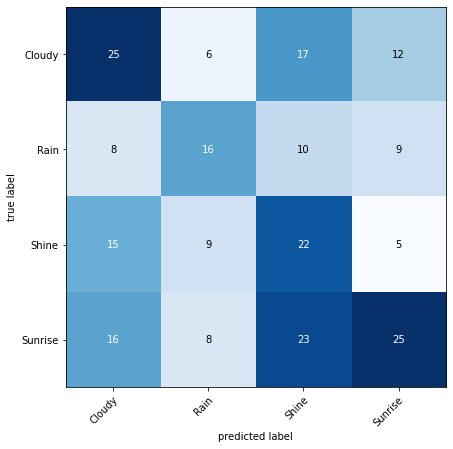

In [17]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_dataloader.dataset.targets).int())

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [18]:
labels = torch.Tensor(test_dataloader.dataset.targets).int()

In [ ]:
labels.shape

torch.Size([75])

In [ ]:
sorted.indices[0:5]

tensor([58, 17, 20, 63, 38])

In [21]:
images=test_dataloader.dataset.imgs

In [22]:
[images[x] for x in [58, 17, 20, 63, 38]]

[('/content/drive/MyDrive/weatherdataset_splited/val/Cloudy/cloudy92.jpg', 0),
 ('/content/drive/MyDrive/weatherdataset_splited/val/Cloudy/cloudy152.jpg', 0),
 ('/content/drive/MyDrive/weatherdataset_splited/val/Cloudy/cloudy166.jpg', 0),
 ('/content/drive/MyDrive/weatherdataset_splited/val/Rain/rain106.jpg', 1),
 ('/content/drive/MyDrive/weatherdataset_splited/val/Cloudy/cloudy256.jpg', 0)]

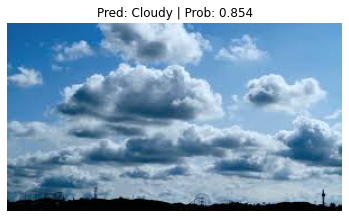

In [24]:
from scipy.spatial import transform
from going_modular.going_modular import predictions

predictions.pred_and_plot_image(model_0,class_names,'/content/drive/MyDrive/weatherdataset_splited/val/Cloudy/cloudy92.jpg',(224,224),transform=simple_transform,device=device)

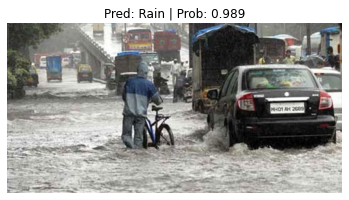

In [25]:
predictions.pred_and_plot_image(model_0,class_names,'/content/drive/MyDrive/weatherdataset_splited/val/Rain/rain106.jpg',(224,224),transform=simple_transform,device=device)